
Using local installation of Fiji with Flimlib installed and full gui support
Optional to use server : Refer [here Link](https://nbviewer.jupyter.org/github/imagej/tutorials/blob/master/notebooks/1-Using-ImageJ/6-ImageJ-with-Python-Kernel.ipynb)



In [1]:

import imagej
ij_local_installation=r'C:\Fiji.app'
ij = imagej.init(ij_local_installation,headless=False)
ij.ui().showUI()

Added 413 JARs to the Java classpath.


In [2]:

#using python based sdt reader for support for compressed and simulated datasets

import sdtfile as sdt
test_sdtfile=sdt.SdtFile(r'../test_files/cells.sdt')
test_data=test_sdtfile.data[0].transpose(2,1,0)


In [3]:
#see the data in the imagej GUI

ij.ui().show('test_data.sdt',ij.py.to_java(test_data))

In [4]:
# for reading parameters from the GUI

from jnius import autoclass
WindowManager = autoclass('ij.WindowManager')
img = WindowManager.getCurrentImage()
#img.changes = False
img.getDimensions(),img.getID(),img.getTitle(),img.getProperties()

([256, 256, 256, 1, 1], -2, 'test_data.sdt', None)

In [5]:
# Running a groovy script to fit the open file using flim.fitRLD

ij.script().run('macro.groovy',
"""
# @ImageJ ij
# @ImgPlus img

op = ij.op()

import flimlib.flimj.FitParams
param = new FitParams()
param.transMap = img;

param.xInc=10.4/256
param.ltAxis = 2

rldRslt = op.run("flim.fitRLD", param)

rldRslt.paramMap
""" , True).get()

<org.scijava.script.ScriptModule at 0x22608898308 jclass=org/scijava/script/ScriptModule jself=<LocalRef obj=0x77155670 at 0x2260889a6f0>>

In [6]:
# read the result window
fit_result= ij.py.from_java(WindowManager.getCurrentImage())
fit_result.shape, fit_result.mean(2).mean(1)

((3, 256, 256), array([-1.36664264e-03,  5.01503887e-01,  2.09831249e+00]))

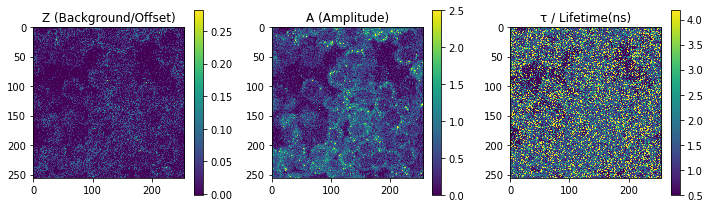

In [7]:
# Show the outputs

import matplotlib.pyplot as plt
plt.figure(figsize=[10,3])

plt.subplot(131)
plt.imshow(fit_result[0],vmin=fit_result[0].mean())
plt.colorbar()
plt.title('Z (Background/Offset)')

plt.subplot(132)
plt.imshow(fit_result[1],vmax=fit_result[1].mean()*5)
plt.colorbar()
plt.title('A (Amplitude)')

plt.subplot(133)
plt.imshow(fit_result[2],vmax=fit_result[2].mean()*2,vmin=0.5)
plt.colorbar()
plt.title('τ / Lifetime(ns)')

plt.tight_layout()

In [8]:
## close all imagej windows using ijm script

ij.py.run_macro("""run("Close All");""")

<org.scijava.script.ScriptModule at 0x226075bbc50 jclass=org/scijava/script/ScriptModule jself=<LocalRef obj=0x793fe2a0 at 0x22609217e10>>

In [9]:
## additional tools  Memory Manamagent  

from jnius import autoclass
Runtime = autoclass('java.lang.Runtime')
def java_mem():
    rt = Runtime.getRuntime()
    mem_max = rt.maxMemory()
    mem_used = rt.totalMemory() - rt.freeMemory()
    return '{} of {} MB ({}%)'.format(
        int(mem_used / 2**20),
        int(mem_max / 2**20),
        int(100 * mem_used / mem_max))


In [10]:
print('OPENED WINDOWS:', ij.py.from_java(ij.window().getOpenWindows()))
print(java_mem())
ij.window().clear()
print('OPENED WINDOWS:', ij.py.from_java(ij.window().getOpenWindows()))
print(java_mem())

OPENED WINDOWS: []
167 of 27305 MB (0%)
OPENED WINDOWS: []
167 of 27305 MB (0%)
